# Delivery time prediction


In [211]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.base import BaseEstimator, TransformerMixin
from math import radians, sin, cos, sqrt, atan2
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

pd.options.display.max_rows = 3

sys.path.append(
    "/Users/skronski/Documents/Projects/e_commerce/00_programs/00_project_setup"
)
from directories import directories_path_setup
from directories import update_gitignore
from directories import reading_files

#

directories = directories_path_setup(
    "e_commerce", "/Users/skronski/Documents/Projects/"
)
files_dict = reading_files(directories)

olist_sellers_dataset = files_dict["olist_sellers_dataset"]
product_category_name_translation = files_dict["product_category_name_translation"]
olist_orders_dataset = files_dict["olist_orders_dataset"]
olist_order_items_dataset = files_dict["olist_order_items_dataset"]
olist_customers_dataset = files_dict["olist_customers_dataset"]
olist_order_payments_dataset = files_dict["olist_order_payments_dataset"]
olist_order_reviews_dataset = files_dict["olist_order_reviews_dataset"]
olist_products_dataset = files_dict["olist_products_dataset"]
olist_geolocation_dataset = files_dict["olist_geolocation_dataset"]
olist_geolocation_dataset["geolocation_zip_code_prefix"] = olist_geolocation_dataset[
    "geolocation_zip_code_prefix"
].astype(int)
olist_customers_dataset["customer_zip_code_prefix"] = olist_customers_dataset[
    "customer_zip_code_prefix"
].astype(int)

The /Users/skronski/Documents/Projects/e_commerce/00_programs exists already.
The /Users/skronski/Documents/Projects/e_commerce/01_input exists already.
The /Users/skronski/Documents/Projects/e_commerce/02_output exists already.
The /Users/skronski/Documents/Projects/e_commerce/03_temporary exists already.
['/Users/skronski/Documents/Projects/e_commerce/01_input/olist_sellers_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/product_category_name_translation.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_orders_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_order_items_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_customers_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_geolocation_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_order_payments_dataset.csv', '/Users/skronski/Documents/Projects/e_commerce/01_input/olist_order_reviews

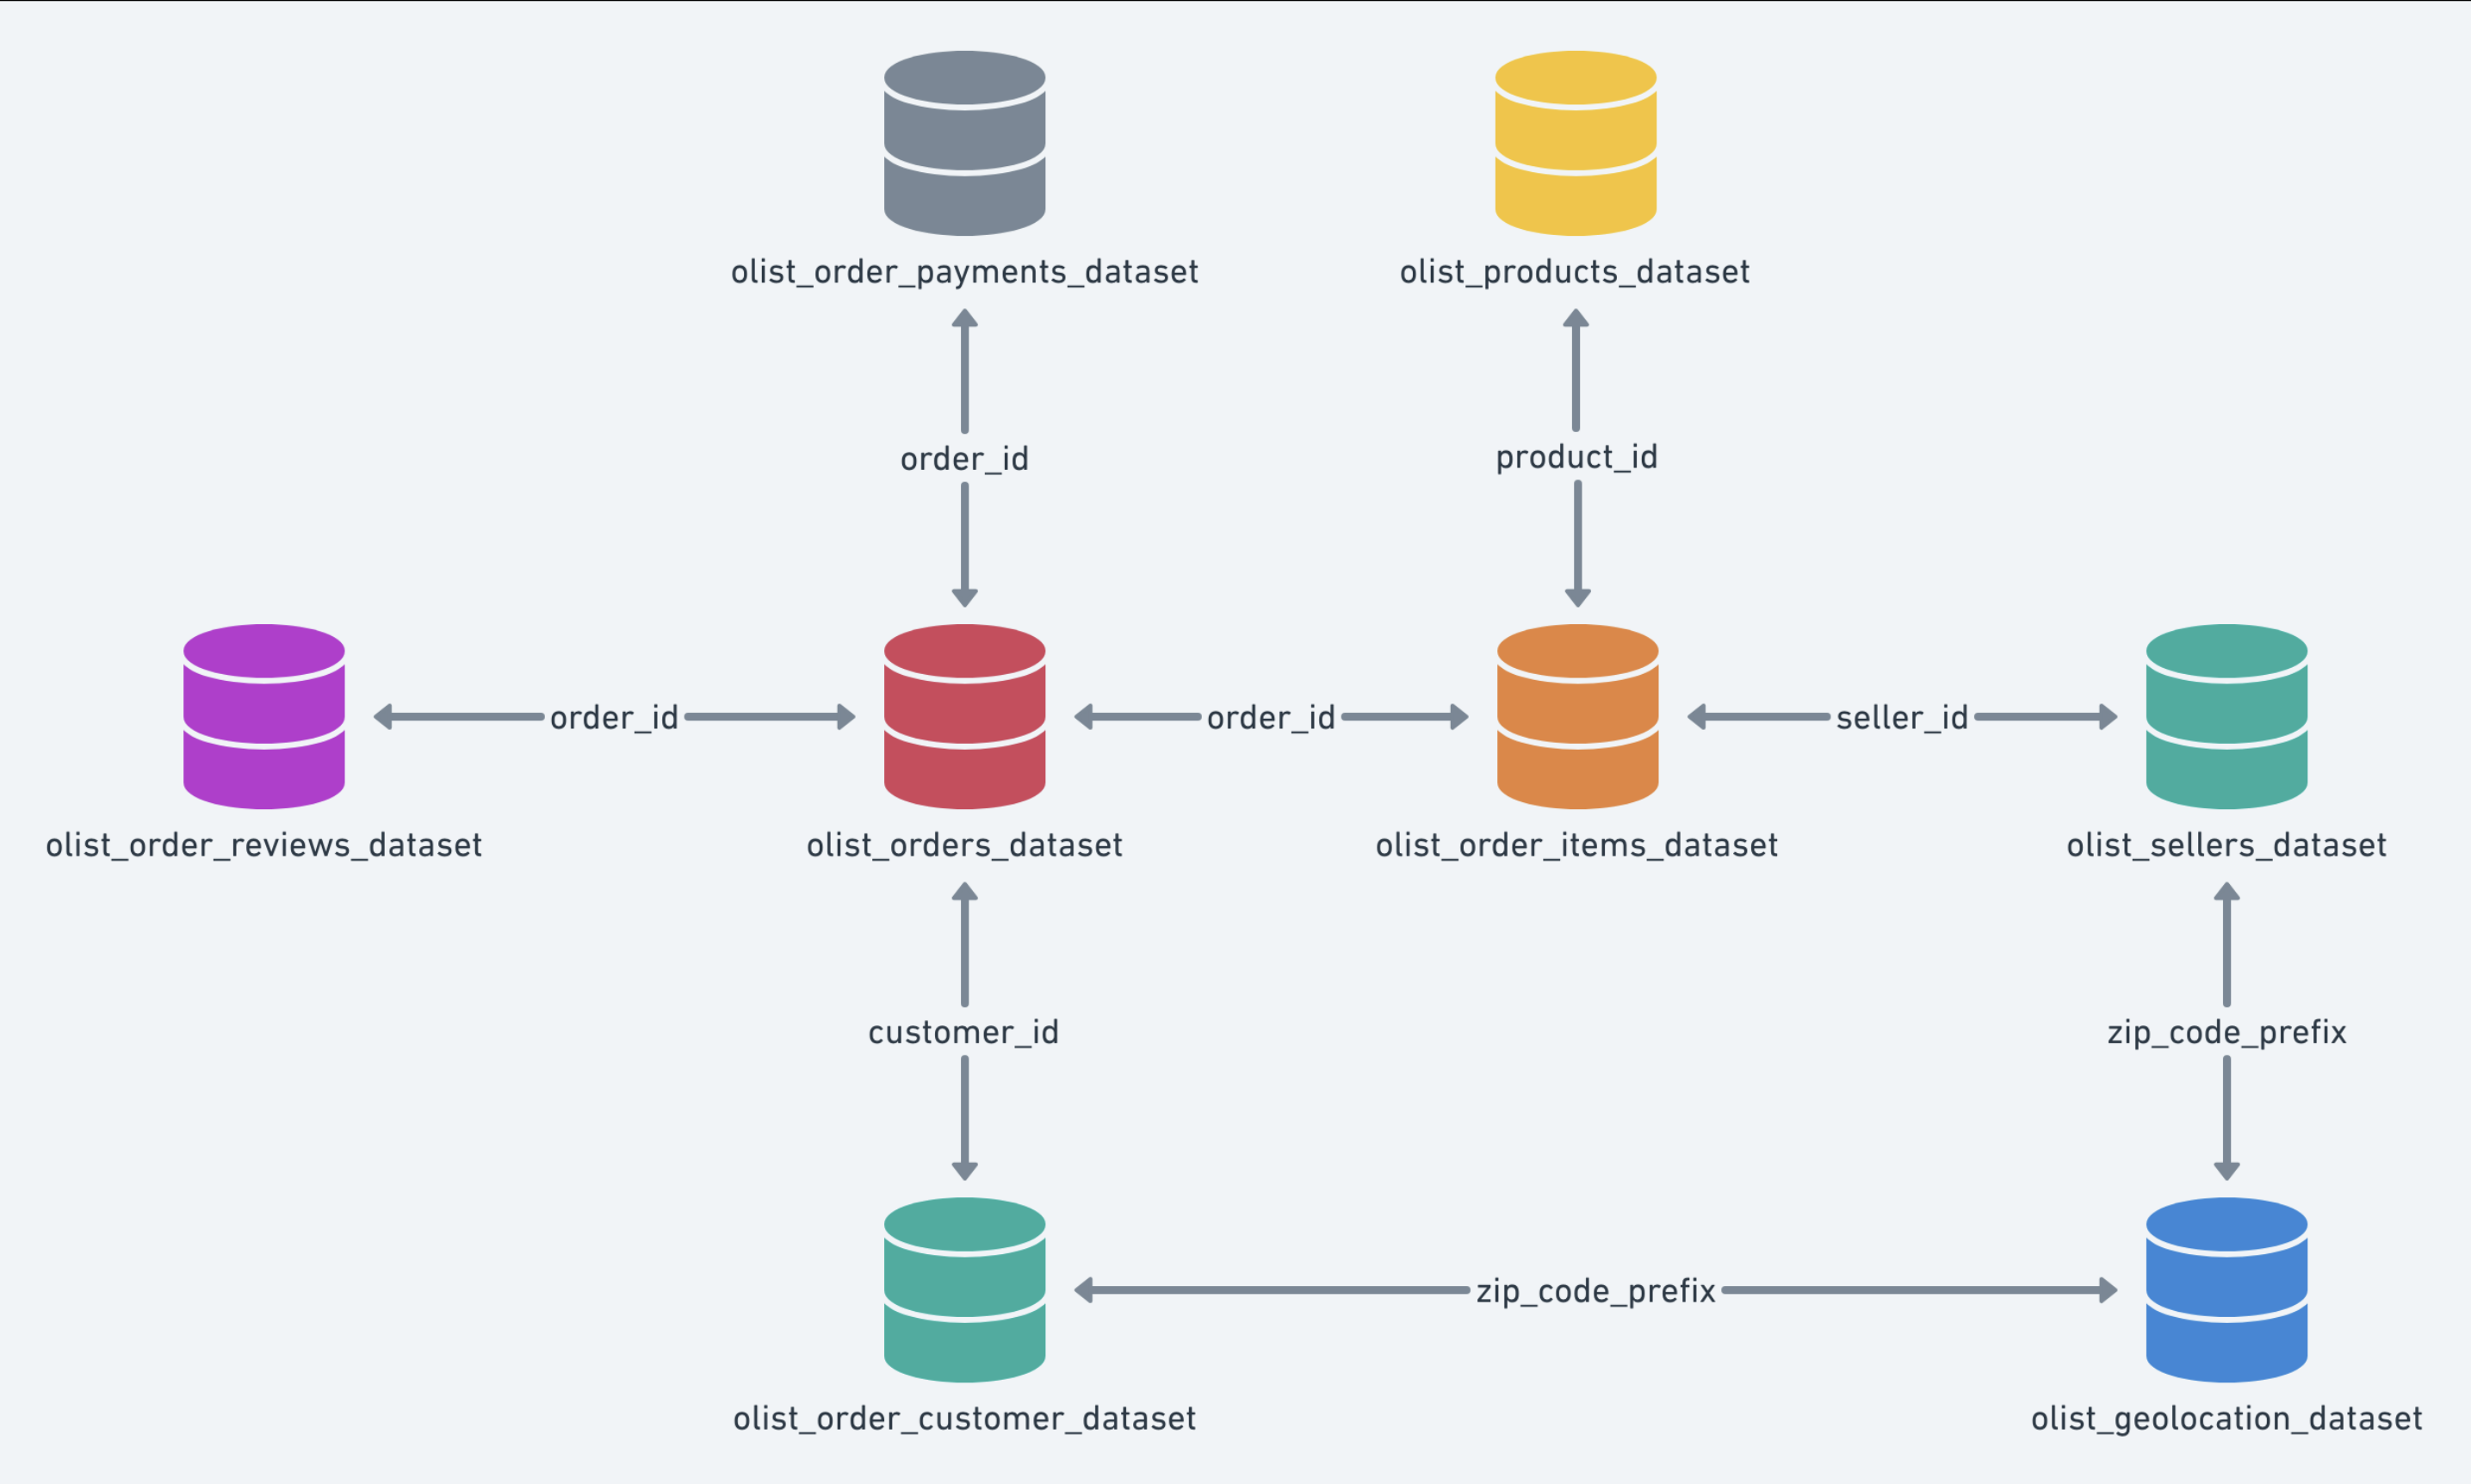 

# Feature ideas:
- difference between purchase and aproved 
- volume of package 
- number of products in order
- kilometers diff (seler - buyer)
- citisize category
# make better prediction than "estimated time"
what is the diff

In [212]:
olist_order_items_dataset

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
...,...,...,...,...,...,...,...
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.0,12.79


In [213]:
olist_products_dataset

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
...,...,...,...,...,...,...,...,...,...
32950,106392145fca363410d287a815be6de4,cama_mesa_banho,58.0,309.0,1.0,2083.0,12.0,2.0,7.0


In [214]:
olist_orders_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
...,...,...,...,...,...,...,...,...
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


In [215]:
olist_products_dataset

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
...,...,...,...,...,...,...,...,...,...
32950,106392145fca363410d287a815be6de4,cama_mesa_banho,58.0,309.0,1.0,2083.0,12.0,2.0,7.0


In [216]:
olist_customers_dataset

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
...,...,...,...,...,...
99440,274fa6071e5e17fe303b9748641082c8,84732c5050c01db9b23e19ba39899398,6703,cotia,SP


In [217]:
olist_geolocation_dataset

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
...,...,...,...,...,...
1000162,99950,-28.070104,-52.018658,tapejara,RS


# Joining data


In [218]:
orders_items = pd.merge(
    olist_orders_dataset, olist_order_items_dataset, how="left", on="order_id"
)
orders_items_product = pd.merge(
    orders_items, olist_products_dataset, how="left", on="product_id"
)

orders_items_product_customer = pd.merge(
    orders_items_product, olist_customers_dataset, how="left", on="customer_id"
)

orders_items_product_customer_seller = pd.merge(
    orders_items_product_customer, olist_sellers_dataset, how="left", on="seller_id"
)

In [219]:
df = orders_items_product_customer_seller
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   order_item_id                  112650 non-null  float64
 9   product_id                     112650 non-null  object 
 10  seller_id                      112650 non-null  object 
 11  shipping_limit_date            112650 non-null  object 
 12  price                         

## Date formatting

In [221]:
datetime_columns = [
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
    "order_purchase_timestamp",
]
df[datetime_columns]

,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,order_purchase_timestamp
0,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2017-10-06 11:07:15,2017-10-02 10:56:33
...,...,...,...,...,...,...
113424,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00,2018-03-15 10:55:42,2018-03-08 20:57:30


In [222]:
for col in datetime_columns:
    df.loc[:, col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")

# Target variable

In [223]:
df["target_estimated_delivery_time"] = (
    df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
).apply(lambda x: x.days)
df["order_estimated_delivery_time"] = (
    df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]
).apply(lambda x: x.days)

In [224]:
df.dropna(subset=["target_estimated_delivery_time"], inplace=True)
df.dropna(subset=["order_estimated_delivery_date"], inplace=True)

# Kilometers diffrence transformer

In [225]:
class KilometerDiffTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, olist_geolocation_dataset):
        self.olist_geolocation_dataset = olist_geolocation_dataset
        self.city_center_lat = pd.DataFrame()
        self.city_center_lng = pd.DataFrame()

    def fit(self, X, y=None):
        self.city_center_lat = self.olist_geolocation_dataset.groupby(
            by=["geolocation_city", "geolocation_state", "geolocation_zip_code_prefix"],
            as_index=False,
        ).agg(geolocation_lat=("geolocation_lat", "mean"))
        self.city_center_lng = self.olist_geolocation_dataset.groupby(
            by=["geolocation_city", "geolocation_state", "geolocation_zip_code_prefix"],
            as_index=False,
        ).agg(geolocation_lng=("geolocation_lng", "mean"))

        return self

    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """
        Calculate the distance between two points on the Earth given their latitude and longitude
           in decimal degrees using the Haversine formula.
        """
        # Convert latitude and longitude from decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = 6371 * c  # Earth radius in kilometers

        return distance

    def transform(self, X):
        X_transformed = X.copy()
        city_to_latitude = dict(
            zip(
                self.city_center_lat["geolocation_city"],
                self.city_center_lat["geolocation_lat"],
            )
        )
        X_transformed["customer_city_lat"] = X_transformed["customer_city"].map(
            city_to_latitude
        )
        city_to_longitude = dict(
            zip(
                self.city_center_lng["geolocation_city"],
                self.city_center_lng["geolocation_lng"],
            )
        )

        X_transformed["customer_city_lat"] = X_transformed["customer_city"].map(
            city_to_latitude
        )
        X_transformed["customer_city_lng"] = X_transformed["customer_city"].map(
            city_to_longitude
        )
        X_transformed["seller_city_lat"] = X_transformed["seller_city"].map(
            city_to_latitude
        )
        X_transformed["seller_city_lng"] = X_transformed["seller_city"].map(
            city_to_longitude
        )
        X_transformed["distance_km"] = X_transformed.apply(
            lambda row: self.haversine_distance(
                row["customer_city_lat"],
                row["customer_city_lng"],
                row["seller_city_lat"],
                row["seller_city_lng"],
            ),
            axis=1,
        )
        columns_to_drop = [
            "customer_city_lat",
            "customer_city_lng",
            "seller_city_lat",
            "seller_city_lng",
        ]
        X_transformed = X_transformed.drop(columns=columns_to_drop)
        return X_transformed

    def names_of_columns(self):
        return ["distance_km"]

# Average delivery time for the city 

In [226]:
X = df.drop(columns="target_estimated_delivery_time")
y = df["target_estimated_delivery_time"]
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [227]:
X_train

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,order_estimated_delivery_time
87795,6f295b89fc3e13345e3d9748140bfec7,f775aeb6ab62c3044f1f717dbdca6923,delivered,2017-06-05 02:09:00,2017-06-05 02:22:04,2017-06-06 12:56:22,2017-06-16 13:22:08,2017-06-28 00:00:00,1.0,3ece1fcd5a64459a4e24143920178f42,...,11.0,11.0,c18e9bc6105e23984e0beed4b3dfda3f,96180,camaqua,RS,80310.0,curitiba,PR,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16239,d0b9bcb0d474f6525456037afe12820f,2234c43d78384c202447f319adeba1c4,delivered,2017-09-02 13:20:52,2017-09-05 04:24:49,2017-09-15 15:17:29,2017-09-20 19:10:45,2017-09-22 00:00:00,1.0,70358ca9f95694a2b9e41eed6edbd7b3,...,2.0,28.0,e725bc81f23cb13cbe705fdbcf49f581,14051,ribeirao preto,SP,31255.0,belo horizonte,MG,19


In [228]:
class AverageTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.df_time = pd.DataFrame()
        self.mean_delivery_time = None

    def fit(self, X, y=None):
        X_fit = X.copy()
        X_fit["target_estimated_delivery_time"] = y
        self.df_time = X_fit.groupby("customer_city", as_index=False).agg(
            average_time_by_city=("target_estimated_delivery_time", "mean")
        )
        self.mean_delivery_time = np.nanmean(X_fit["target_estimated_delivery_time"])
        return self

    def transform(self, X):
        X_transformed = pd.merge(X, self.df_time, on="customer_city", how="left")
        X_transformed["average_time_by_city"] = X_transformed[
            "average_time_by_city"
        ].fillna(self.mean_delivery_time)
        return X_transformed

    def names_of_columns(self):
        return ["average_time_by_city"]

In [229]:
class VolumeCalculator(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed["volume_of_product"] = (
            X_transformed["product_length_cm"]
            * X_transformed["product_height_cm"]
            * X_transformed["product_width_cm"]
        )
        X_transformed["volume_weight_ratio"] = (
            X_transformed["product_weight_g"] / X_transformed["volume_of_product"]
        )
        return X_transformed

    def names_of_columns(self):
        return ["volume_of_product", "volume_weight_ratio"]

# Drop irrelevant columns

In [199]:
df = df.drop(
    columns=[
        "order_id",
        "customer_id",
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "order_item_id",
        "product_id",
        "seller_id",
        "shipping_limit_date",
        "customer_unique_id",
        "order_status",
    ]
)
df

,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,target_estimated_delivery_time,order_estimated_delivery_time
0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3149,sao paulo,SP,9350.0,maua,SP,8.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113424,68.50,18.36,beleza_saude,45.0,569.0,1.0,150.0,16.0,7.0,15.0,83750,lapa,PR,14407.0,franca,SP,7.0,25


In [200]:
X = df.drop(columns="target_estimated_delivery_time")
y = df["target_estimated_delivery_time"]
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Proof of concept


In [201]:
kilometers_diff = Pipeline(
    [("km", KilometerDiffTransformer(olist_geolocation_dataset))]
)

# Define categorical and numerical columns
categorical_cols = []  # ["product_category_name"]
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Create pipeline for preprocessing
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# Add XGBoost model to the pipeline
model = Pipeline(
    steps=[
        ("volume", VolumeCalculator()),
        ("avg_time", AverageTime()),
        ("km", kilometers_diff),
        ("preprocessor", preprocessor),
        ("regressor", xgb.XGBRegressor(objective="reg:squarederror", random_state=42)),
    ]
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set and evaluate the model
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 7.756092806654405


In [202]:
x_vol = model["volume"].transform(X_test)
x_avg = model["avg_time"].transform(x_vol)
x_km = model["km"].fit_transform(x_avg)
num_cols = x_km.columns
new_cat_cols = (
    model.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_cols)
)

'new_cat_cols = (\n    model.named_steps["preprocessor"]\n    .named_transformers_["cat"]\n    .named_steps["onehot"]\n    .get_feature_names_out(categorical_cols)\n)'

In [203]:
all_cols = np.concatenate([num_cols, new_cat_cols])

In [207]:
all_cols

array(['price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_estimated_delivery_time', 'volume_of_product',
       'volume_weight_ratio', 'average_time_by_city', 'distance_km'],
      dtype=object)

In [204]:
import shap

# Extract the model from the pipeline
model_1 = model.named_steps["regressor"]

# Extract the preprocessor from the pipeline
preprocessor = model.named_steps["preprocessor"]

# Assuming you have your test data as X_test
# Transform the test data using the preprocessor
X_test_transformed = preprocessor.transform(x_km)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model_1)
shap_values = explainer.shap_values(X_test_transformed)

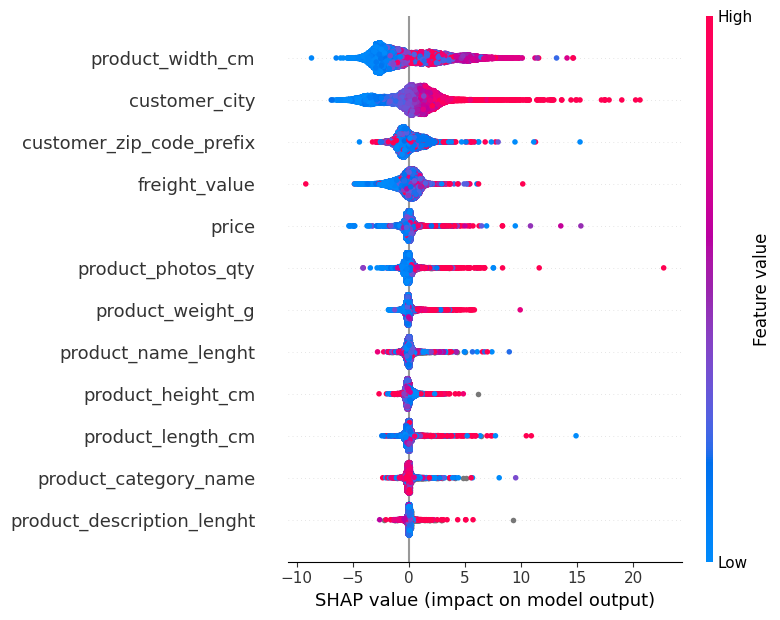

In [205]:
# Plot the SHAP values
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=all_cols)

# Show the plot

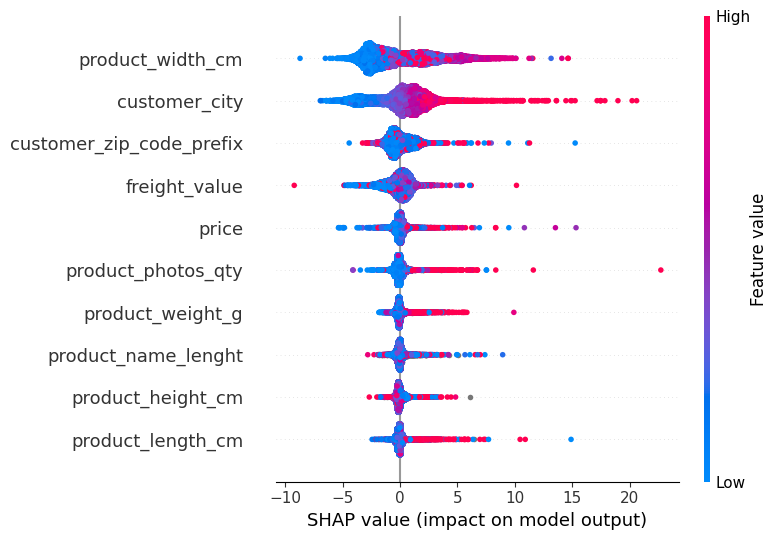

In [206]:
# Calculate the absolute mean SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)

# Get the indices of the top 10 most important features
top_10_indices = np.argsort(mean_shap_values)[-10:]

# Get the names of the top 10 most important features
top_10_features = [X_test.columns[i] for i in top_10_indices]

# Get the SHAP values for the top 10 features
top_10_shap_values = shap_values[:, top_10_indices]

# Plot the SHAP values for the top 10 features
shap.summary_plot(
    top_10_shap_values,
    features=X_test_transformed[:, top_10_indices],
    feature_names=top_10_features,
)

# Show the plot
plt.show()

In [113]:
y_whole_pred = model.predict(X)

In [114]:
rmse = root_mean_squared_error(y_whole_pred, y)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 7.074583927676384


In [115]:
rmse = root_mean_squared_error(df["order_estimated_delivery_time"], y)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 15.302203389767099


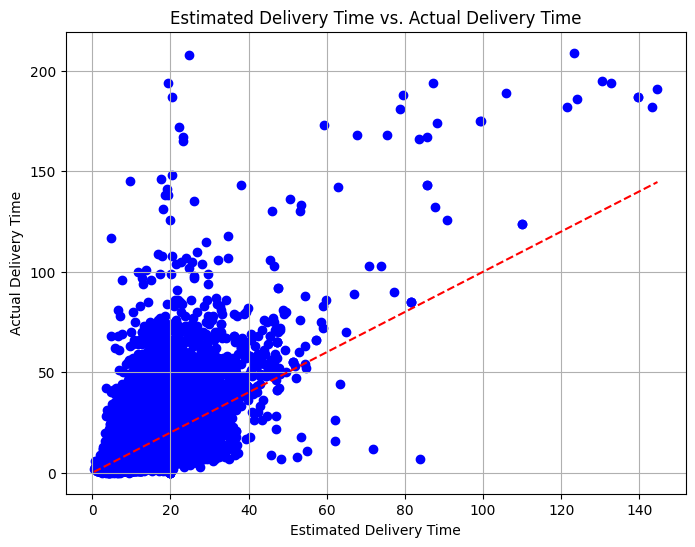

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(y_whole_pred, y, color="blue")
plt.plot(
    [min(y_whole_pred), max(y_whole_pred)],
    [min(y_whole_pred), max(y_whole_pred)],
    color="red",
    linestyle="--",
)
plt.title("Estimated Delivery Time vs. Actual Delivery Time")
plt.xlabel("Estimated Delivery Time")
plt.ylabel("Actual Delivery Time")
plt.grid(True)
plt.show()

Our predictions have smaller root mean squared error

# Proof of concept showed us that improvment of prediction of delivery time is possible

In [123]:
# Define the parameter grid for XGBoost hyperparameters
param_grid = {
    "regressor__n_estimators": [100, 200, 300],
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.1, 0.01, 0.001],
    "regressor__gamma": [0, 0.1, 0.2],
    "regressor__subsample": [0.6, 0.8, 1.0],
    "regressor__colsample_bytree": [0.6, 0.8, 1.0],
    "regressor__reg_alpha": [0, 0.1, 0.5],
    "regressor__reg_lambda": [0, 0.1, 1.0],
}

random_search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    verbose=2,
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)

# Get the best estimator
best_model_random = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_random = best_model_random.predict(X_test)

# Calculate RMSE
rmse_random = root_mean_squared_error(y_test, y_pred_random)
print("Root Mean Squared Error (Randomized Search):", rmse_random)

# Number of models left
models_left = 100 - random_search.cv_results_["mean_fit_time"].shape[0]
print("Number of models left:", models_left)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.001, regressor__max_depth=7, regressor__n_estimators=300, regressor__reg_alpha=0, regressor__reg_lambda=0, regressor__subsample=1.0; total time=   1.9s
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.001, regressor__max_depth=7, regressor__n_estimators=300, regressor__reg_alpha=0, regressor__reg_lambda=0, regressor__subsample=1.0; total time=   1.9s
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.001, regressor__max_depth=7, regressor__n_estimators=300, regressor__reg_alpha=0, regressor__reg_lambda=0, regressor__subsample=1.0; total time=   1.9s
[CV] END regressor__colsample_bytree=0.6, regressor__gamma=0.1, regressor__learning_rate=0.001, regressor__max_depth=7, regressor__n_estimators=300, regressor__reg_alpha=0, regressor__reg_lambda=0, regressor_

In [19]:
import joblib

model_path = "/Users/skronski/Documents/Projects/e_commerce/00_programs/04_delivery_experience/best_xgboost_model.pkl"

In [124]:
# Define the full path to save the model

# Save the best model to the specified location
joblib.dump(best_model_random, model_path)

['/Users/skronski/Documents/Projects/e_commerce/00_programs/04_delivery_experience/best_xgboost_model.pkl']

In [230]:
# Load the saved model from the specified location
loaded_model = joblib.load(model_path)

In [231]:
loaded_model

Pipeline(steps=[('volume', <__main__.VolumeCalculator object at 0x2daa7aa90>),
                ('avg_time', AverageTime()),
                ('km',
                 Pipeline(steps=[('km',
                                  KilometerDiffTransformer(olist_geolocation_dataset=         geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                               1037       -23.545621       -46.639292   
...                              ...              ...              ...   
1000162                        99950       -28.070104       -52.018658   

        geolocation_city geolocation_state  
0              sao paulo                S...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [232]:
# Make predictions on the test set using the best model
y_pred_random = loaded_model.predict(X_test)

# Calculate RMSE
rmse_random = root_mean_squared_error(y_test, y_pred_random)
print("Root Mean Squared Error (Randomized Search):", rmse_random)

Root Mean Squared Error (Randomized Search): 7.692381663945863


# Best features

In [233]:
pd.options.display.max_rows = 10

# Get feature importances from the trained XGBoost model
feature_importances = loaded_model.named_steps["regressor"].feature_importances_

# Get the names of the features after preprocessing
numeric_feature_names = loaded_model.named_steps["preprocessor"].transformers_[0][2]
categorical_feature_names = (
    loaded_model.named_steps["preprocessor"]
    .transformers_[1][1]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_cols)
)

# Concatenate numerical and categorical feature names
feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Create a DataFrame to store feature importances with their names
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

feature_importance_df.head(10)

ValueError: input_features is not equal to feature_names_in_

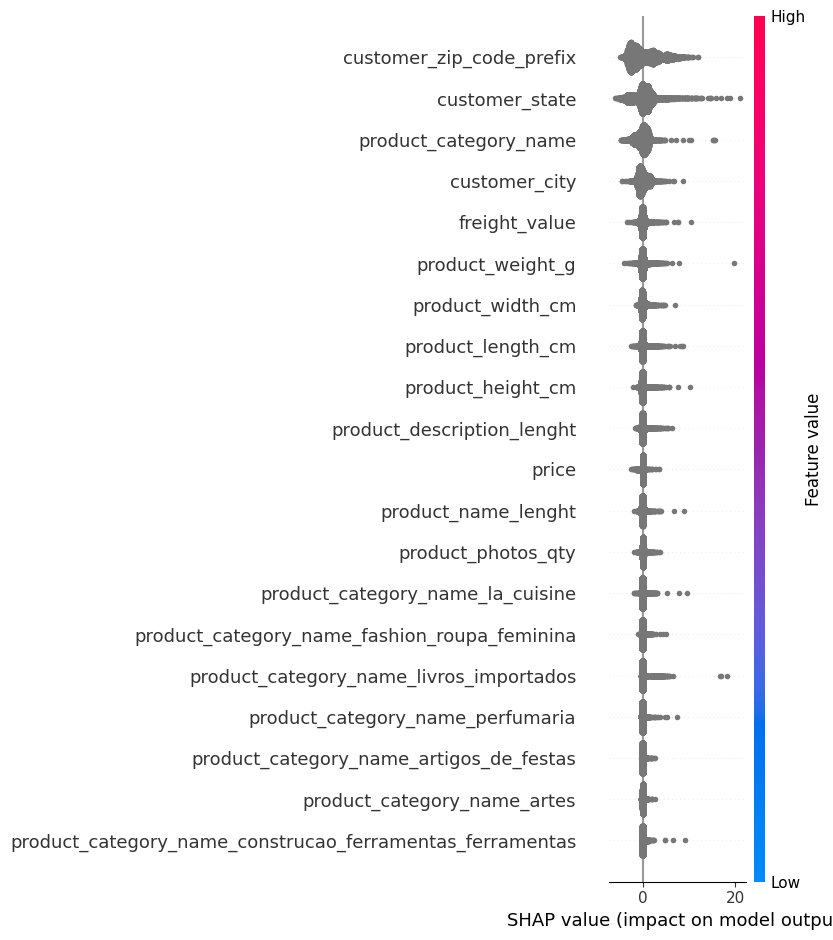

In [237]:
import shap

all_cols = np.concatenate([num_cols, new_cat_cols])
# Extract the model from the pipeline
model_1 = loaded_model.named_steps["regressor"]

# Extract the preprocessor from the pipeline
preprocessor = loaded_model.named_steps["preprocessor"]

# Assuming you have your test data as X_test
# Transform the test data using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model_1)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, features=X_test_transformed, feature_names=all_cols)